# Imports

In [1]:
import tarfile
import numpy as np

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
from scipy.io import readsav

In [4]:
import os

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model


In [6]:
import sunpy
import sunpy.map

# Useful General Functions

In [7]:
def get_file_paths(directory_path):
    """
    Given a directory path, this function returns a list of full file paths
    for all the files within the given directory.

    Parameters:
    - directory_path (str): The path to the directory from which to list files.

    Returns:
    - List[str]: A list of full file paths.
    """
    # List to hold file paths
    file_paths = []

    # Check if the directory exists
    if not os.path.isdir(directory_path):
        raise ValueError(f"The provided directory path does not exist: {directory_path}")

    # Walk the directory tree
    for root, _, files in os.walk(directory_path):
        for file in files:
            # Concatenate the root directory and file name to get the full path
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    return file_paths

"""
# Test
im = get_file_paths("G:\\BMR_Identification")
img = image_data_generator(im)
image = next(img)

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Image Data from IDL .sav file')
plt.show()
"""

'\n# Test\nim = get_file_paths("G:\\BMR_Identification")\nimg = image_data_generator(im)\nimage = next(img)\n\nplt.figure(figsize=(10, 10))\nplt.imshow(image, cmap=\'gray\', origin=\'lower\')\nplt.colorbar()\nplt.title(\'Image Data from IDL .sav file\')\nplt.show()\n'

In [8]:
def combined_generator(x_generator, y_generator, batch_size):
    while True:  # Loop indefinitely
        X_batch = []
        Y_batch = []
        
        for _ in range(batch_size):
            X_batch.append(next(x_generator))
            Y_batch.append(next(y_generator))
        
        # Convert to numpy arrays and yield the batches
        yield (np.array(X_batch), np.array(Y_batch))


# Sun Image

Filename: C:\Users\ASUS\Downloads\mdi.fd_ic_interp.19960423_000000_TAI.data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    109   (1024, 1024)   int32   
HDU 0 does not contain image data.
HDU 1 contains image data with shape: (1024, 1024)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


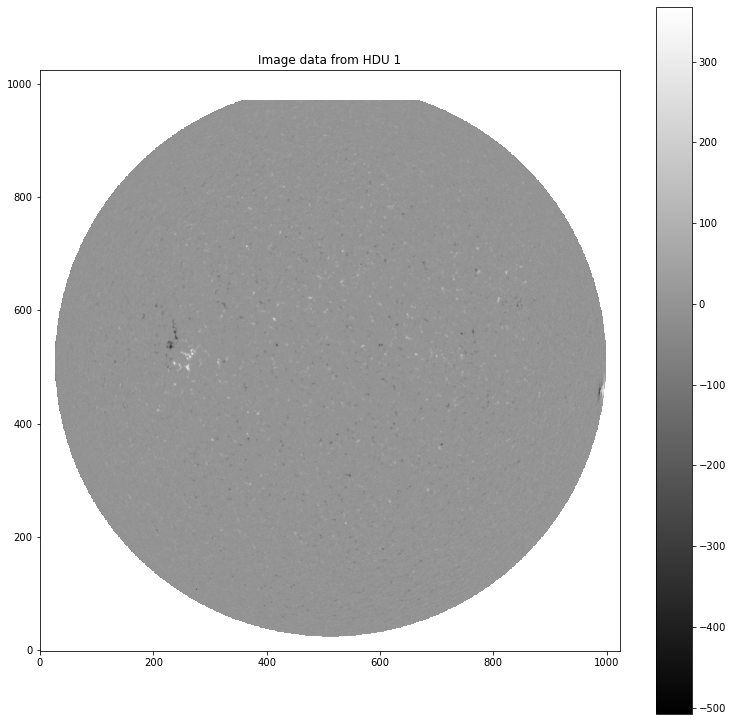

In [6]:
fits_file_path = "C:\\Users\\ASUS\\Downloads\\mdi.fd_ic_interp.19960423_000000_TAI.data.fits"

# Open the FITS file to read the data
with fits.open(fits_file_path) as hdul:
    # Get info to see the structure of the HDU list
    hdul.info()
    
    # Iterate over the HDUs safely
    for index in range(len(hdul)):
        hdu = hdul[index]
        if hdu.is_image and hdu.data is not None:
            print(f"HDU {index} contains image data with shape: {hdu.data.shape}")
            # If it's the correct HDU with image data, visualize it
            print(hdu.data)
            
            plt.figure(figsize = (13,13))
            plt.imshow(hdu.data, cmap='gray', origin='lower')
            plt.colorbar()
            plt.title(f'Image data from HDU {index}')
            plt.show()
            
            break
        else:
            print(f"HDU {index} does not contain image data.")

# Converting Sun Image into Desired Format

In [9]:
def load_fits_image_sunpy(fits_file_path, vmin=-1500, vmax=1500):
    # Use sunpy to open the FITS file
    magnetogram_map = sunpy.map.Map(fits_file_path)
    image_data = magnetogram_map.data.astype(np.float32)  # Ensure data is in float32
    
    # Clip the data to be within the range [vmin, vmax]
    image_data = np.clip(image_data, vmin, vmax)
    
    # Normalize the clipped image data to [0, 1]
    image_data = (image_data - vmin) / (vmax - vmin)
    
    return image_data

def sun_data_generator(file_paths):
    for file_path in file_paths:
        yield load_fits_image_sunpy(file_path)

In [28]:
def load_fits_image(fits_file_path):
    # Open the FITS file to read the data
    with fits.open(fits_file_path) as hdul:
        # Assuming the image data is in the second HDU (index 1)
        image_data = hdul[1].data.astype(np.float32)  # Ensure data is in float32 for neural network compatibility
        
        # Handle NaN values if present
        if np.isnan(image_data).any():
            image_data = np.nan_to_num(image_data)
        
        # Normalize the image data to [0, 1]
        image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
        
        # Add a channel dimension if the model expects it
        #image_data = np.expand_dims(image_data, axis=-1)
        
    return image_data

def Sun_data_generator(file_paths):
    for file_path in file_paths:
        yield load_fits_image(file_path)

In [11]:
img = load_fits_image_sunpy(fits_file_path)
plt.figure(figsize = (13,13))
plt.imshow(img, origin='lower')
plt.colorbar()
plt.title(f'Image data from HDU {index}')
plt.show()

NameError: name 'fits_file_path' is not defined

1024


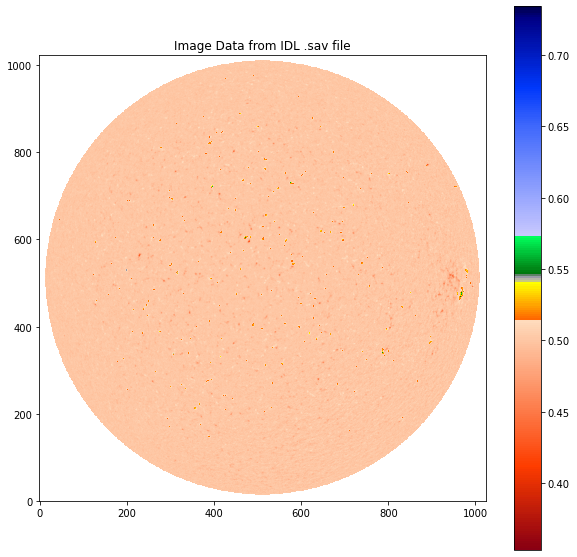

In [13]:
# Test
im = get_file_paths("G:\\Sun_Images_Final")
img = sun_data_generator(im)
image = next(img)
print(len(image))
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='hmimag', origin='lower')
plt.colorbar()
plt.title('Image Data from IDL .sav file')
plt.show()

# BMR Image

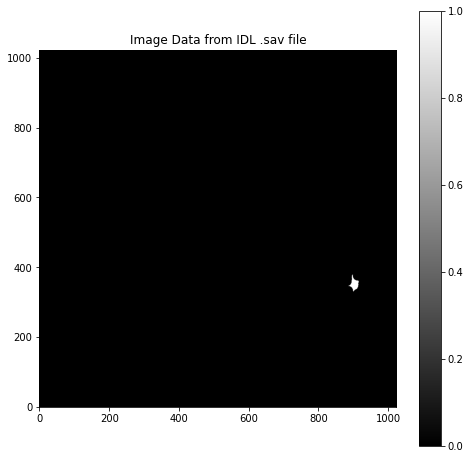

In [14]:

# Replace 'path_to_file.sav' with the path to your .sav file
sav_file_path = "G:\\BMR_Identification\\mdi_bmr_ind_19961228_0448.sav"

# Read the .sav file
idl_data = readsav(sav_file_path)

# Assuming idl_data is already loaded and is a dictionary-like object
# hdr_los would typically be the header with the image's metadata
hdr_los = idl_data['hdr_los']

# Assuming the 'naxis1' and 'naxis2' are attributes of hdr_los that specify the image dimensions
naxis1 = hdr_los.naxis1[0]  # Accessing the first element if it's a one-element array
naxis2 = hdr_los.naxis2[0]  # Accessing the first element if it's a one-element array

# Create an empty image array based on the dimensions specified in the header
image_data = np.zeros((naxis2, naxis1))

# bmr_ind are the indices in the image array that should be set to 1
# We need to convert these indices into 2D indices
# This assumes bmr_ind is a flat index into the 2D image_data array
bmr_ind = idl_data['bmr_ind']

# Calculate the 2D indices from the 1D flat indices
rows, cols = np.divmod(bmr_ind, naxis1)

# Set the specified indices in the image_data array to 1
image_data[rows, cols] = 1

# Now, visualize the image_data array
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Image Data from IDL .sav file')
plt.show()


# Converting BMR images into desired format

In [10]:
def process_sav_file(sav_file_path):
    # Read the .sav file
    idl_data = readsav(sav_file_path)
    
    # Extract image dimensions and indices
    hdr_los = idl_data['hdr_los']
    naxis1 = hdr_los.naxis1[0]
    naxis2 = hdr_los.naxis2[0]
    bmr_ind = idl_data['bmr_ind']
    
    # Convert flat indices to 2D indices
    rows, cols = np.divmod(bmr_ind, naxis1)

    # Create an empty image and set the magnetic regions to 1
    image_data = np.zeros((naxis2, naxis1), dtype=np.float32)
    image_data[rows, cols] = 1.0

    return image_data

def image_data_generator(file_paths):
    for file_path in file_paths:
        yield process_sav_file(file_path)

1024


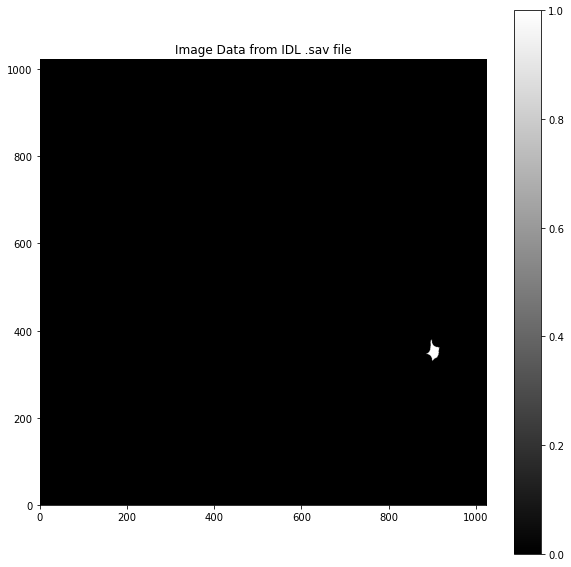

In [31]:
# Test
im = get_file_paths("G:\\BMR_Identification")
img = image_data_generator(im)
image = next(img)
print(len(image))
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', origin='lower')
plt.colorbar()
plt.title('Image Data from IDL .sav file')
plt.show()



# Model

In [13]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    # Define the U-Net architecture here...
    # Example for the first layer (down-sampling):
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # You would add more layers to complete the architecture

    # Example for the last layer (up-sampling and output):
    up9 = UpSampling2D(size=(2, 2))(pool1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)  # Output layer

    model = Model(inputs=[inputs], outputs=[conv10])
    return model

# Instantiate and compile the U-Net model
model = unet(input_size=(1024, 1024, 1))  # Adjust the input size to match your images
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the Model

In [ ]:
# Create your generators
x_generator = Sun_data_generator(list_of_x_files)
y_generator = image_data_generator(list_of_y_files)

# Combine them into a single generator
train_generator = combined_generator(x_generator, y_generator, batch_size=32)

# Calculate the steps per epoch (total_samples / batch_size)
steps_per_epoch = len(list_of_x_files) // 32

# Train the model using the combined generator
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,  # Assuming you have a validation generator
    validation_steps=validation_steps  # Calculate this similarly for validation data
)


In [14]:
# Assuming X_train and Y_train are your prepared datasets
# X_train: array of input images
# Y_train: array of binary masks indicating the magnetic regions

# Train the model
model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_split=0.1)

# Evaluate the model
# Replace X_test and Y_test with your test data and labels
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

NameError: name 'X_train' is not defined